**Hello Everyone**
<br/>
I have been using keras and tensorflow for an year and both have been good with few advantages and limitations.
<br/>
Keras is high level API built on Theano and tensorflow and is easy to use while tensorflow is a complex one.But in flexibility point of view, TF in much more flexible and offers more advanced operations than keras which comes useful while doing research.
*So I then decided to find something which is easy to use, provides the intuition of entire flow control and offers flexibilty of doing advanced operations.*This is where I started to work and fall in love with it.
For the crowd who haven't heard much of it

<br/>
**PyTorch is an Open source Machine Learning library for python, based on Torch.** 
* **The biggest difference between TF and PYtorch is that, in tensorflow, graph is defined statically before running a model whereas in PyTorch, graph construction is dynamic and nodes can be defined, changed and executed on the go.**
* **Building or binding custom extensions written in C, C++ or CUDA is doable with both frameworks. TensorFlow again requires more boiler plate code though is arguably cleaner for supporting multiple types and devices. In PyTorch you simply write an interface and corresponding implementation for each of the CPU and GPU versions.**

* **Compiling the extension is also straight-forward with both frameworks and doesn’t require downloading any headers or source code outside of what’s included with the pip installation.**

This tutorial focusses on implementing Image classification task using PyTorch using Sequential API. The difference between torch.nn and torch.nn.functional is a matter of convenience and taste. *torch.nn is more convenient for methods which have learnable parameters.*
<br/>
**This tutorial is sufficient to create your first model in PyTorch and learn most of it's concepts and this documentation is descriptive as well as elegant.**
<br/>
Initially, I have noticed people face issues in these issues with pytorch:
* **Data Loading**
* **Model Evaluation**
<br/>
so I have intended to make these tasks more simpler in this tutorial. This tutorial is sufficient for building your first classifier using PyTorch and optimizing it using your custom data. It is structured in such way that you can get hold of entire pipeline of Image Classification tasks. Just Fork the kernel and execute it sequentially and you will get practical taste of PyTorch.

Training a classifier involves these steps:
* **Data Loading and Preprocessing**
* **Model Selection**
* **Defining a loss function**
* **Training the classifier, validation and Parameter tuning**
<br/>

Let's dive into all these sequentially using PyTorch.
<br/>
    Let's begin by importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
from torchvision import models
import torch.optim as optim
import torchvision
from matplotlib.ticker import MaxNLocator
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.ion()

**This data is wrongly matched. Please execute this code to have the correct mapping of X and y values**

In [2]:
data = np.load('../input/Sign-language-digits-dataset/X.npy')
target = np.load('../input/Sign-language-digits-dataset/Y.npy')
Y = np.zeros(data.shape[0])
Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2) ## splitting into train and test set

# Custom Data Loading and Processing

Here we are working with numpy arrays which can be directly converted to torch variable for mathematical operations.Many datasets contain images which can be imported using PIL library using
<br/>
**PIL.IMAGE..fromarray(img_name)**
<br/>
We use PIL instead of OpenCV because its Torch default image loader and is compatible with ToTensor() method. The PyTorch website has all the tutorials of this section using their inbuild Dataset class and it can be a toilsome task to load data in case of Custom Dataset.While loading the data, these point should be closely worked upon:
* Setting a batch Size
* Shuffling the data
* Parallelizing the tasks using multiprocecssing workers.
<br/>

The **DataLoader** function  provides all of these features and you can specify them before heading to next task. The label or the target variable can be one an array or one-hot encoded depending on the loss function. For having a look at the different loss functions, please head to [Pytorch loss functions](https://pytorch.org/docs/master/nn.html#loss-functions)

Data loading in PyTorch can be separated in 2 parts:
<br/>
* Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Not that,  the data is not loaded on memory by now.
* The Dataloader reads the data and puts it into memory.

### torchvision
It is used to load and prepare dataset. Using it you can create *transformations* on the input data.
<br/>
#### transforms
It is used for preprocessing images and performing operations sequentially.
<br/>
#### num_workers
It is used for multiprocessing.Normally, **num_workers = 4 * (number of gpus)** works well.


In [3]:
class DatasetProcessing(Dataset):
    def __init__(self, data, target, transform=None): #used to initialise the class variables - transform, data, target
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
        self.target = torch.from_numpy(target).long() # needs to be in torch.LongTensor dtype
    def __getitem__(self, index): #used to retrieve the X and y index value and return it
        return self.transform(self.data[index]), self.target[index]
    def __len__(self): #returns the length of the data
        return len(list(self.data))

In [4]:
transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
dset_train = DatasetProcessing(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=4,
                                          shuffle=True, num_workers=4)

In [5]:
dset_test = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=4,
                                          shuffle=True, num_workers=0)

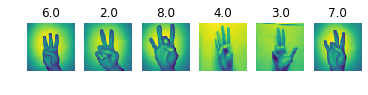

In [6]:
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

# Training

![](https://www.researchgate.net/publication/318174473/figure/fig2/AS:614173574701099@1523441799965/The-topology-of-the-event-driven-Convnet-used-for-this-work-Where-n-is-the-size-of-the.png)








## Define a CNN

Some of the important libraries
### [nn](https://pytorch.org/docs/master/nn.html)
This library contains  function for building conv nets and importing a loss function.
Some loss functions are:
* **binary_cross_entropy**: Function that measures the Binary Cross Entropy between the target and the output.
* **nll_loss**: measures the The negative log likelihood loss.
* **cross_entropy**: This criterion combines log_softmax and nll_loss in a single function.

### [optim](https://pytorch.org/docs/master/optim.html)
torch.optim is a package implementing various optimization algorithms. To construct an Optimizer you have to give it an iterable containing the parameters (all should be Variable s) to optimize. Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc.Some of the optimizers defined by this library are:
* **Adam**: It has been proposed in [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
* **LBFGS**: Implements [L-BFGS algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS).
* **RMSprop**: Proposed by G. Hinton in his [course](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
* **SGD**: Nesterov momentum is based on the formula from [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)
<br/>


Let’s use a **Classification Cross-Entropy loss** and **SGD with momentum**.

In [7]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

<!-- background: #5A0000  -->
<!-- color: #fff -->


# How to use optimizers?
To construct an Optimizer you have to give it an iterable containing the parameters (all should be Variable s) to optimize. Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc.<br/>
*If you want to move the model and variables to cuda, use **model_object.cuda()** and **variable_name.cuda()***

**Follow these steps to build your first model in pytorch**

** Step 1**
####  Clearing the Gradients =>     *optimizer.zero_grad()*
** Clear out the gradients accumulated for the parameters of the network before calling loss.backward() and optimizer.step()**


**Step 2**
#### Compute the loss =>     *criterion( predicted_target, target)*
**Compute the loss between the predicted value and the target value within the loss function previously defined**


**Step 3**
#### Backpropogation =>    *loss.backward()*
**Back-prop all the layers in all the layers of the network**


**Step 4**
#### Taking an optimization step =>     *optimizer.step()*
** Update the parameters of the network **


In [8]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [9]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #print(data.size())
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

## Model Evaluation
Now, it's time to evaluate out model. <br/>
**Note that I have used Functional API( F.cross_entropy( args )) so as to give an idea how it works.**

In [10]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    print('\nAverage Validation loss: {:.5f}\n'.format(loss))

### You can run this model for more  epochs

In [11]:
n_epochs = 15
train_loss = []
valid_loss = []
for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 3.526541
Train Epoch: 0 [800/2020 (40%)]	Loss: 2.848717
Train Epoch: 0 [1200/2020 (59%)]	Loss: 2.251417
Train Epoch: 0 [1600/2020 (79%)]	Loss: 2.504703
Train Epoch: 0 [2000/2020 (99%)]	Loss: 2.335717

Average Validation loss: 2.31718

Train Epoch: 1 [400/2020 (20%)]	Loss: 2.546169
Train Epoch: 1 [800/2020 (40%)]	Loss: 2.269965
Train Epoch: 1 [1200/2020 (59%)]	Loss: 2.233509
Train Epoch: 1 [1600/2020 (79%)]	Loss: 2.247179
Train Epoch: 1 [2000/2020 (99%)]	Loss: 2.223116

Average Validation loss: 2.30415

Train Epoch: 2 [400/2020 (20%)]	Loss: 2.214014
Train Epoch: 2 [800/2020 (40%)]	Loss: 2.350986
Train Epoch: 2 [1200/2020 (59%)]	Loss: 2.319238
Train Epoch: 2 [1600/2020 (79%)]	Loss: 2.305138
Train Epoch: 2 [2000/2020 (99%)]	Loss: 2.279756

Average Validation loss: 2.30682

Train Epoch: 3 [400/2020 (20%)]	Loss: 2.315842
Train Epoch: 3 [800/2020 (40%)]	Loss: 2.307657
Train Epoch: 3 [1200/2020 (59%)]	Loss: 2.290649
Train Epoch: 3 [1600/2020 (79%)]	Loss: 

In [12]:
def plot_graphs(train_loss, valid_loss, epochs):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('train_loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Validation Loss")
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='test')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('vaidation _loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

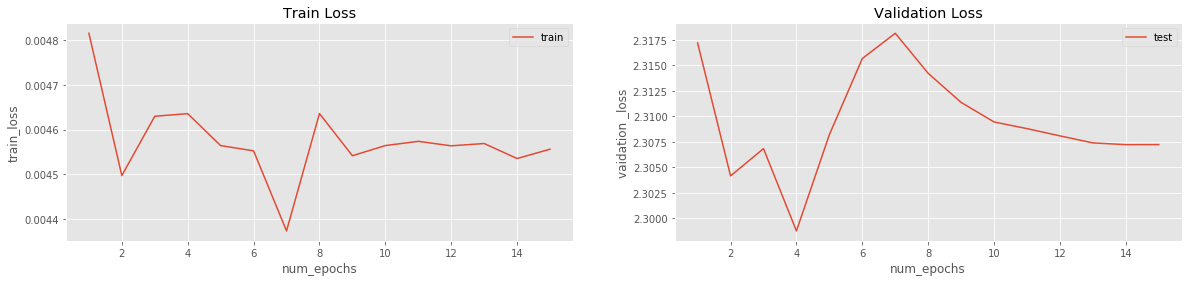

In [13]:
plot_graphs(train_loss, valid_loss, n_epochs)

**One powerful technique to increase the  performance of any deep learning model is through adding more data. So Let's use data augmentationn and see if we get some performance improvement.**

## Data Augmentation

In [14]:
train_transform= transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(), # Hoarizontal Flip
            transforms.Scale(256), #Scaling the input
            transforms.RandomCrop(64, padding=4), # Centre Crop
            transforms.ToTensor(),  #Convereting the input to tensor
            transforms.Normalize([0.5], [0.5])
])
dset_train = DatasetProcessing(X_train, y_train, train_transform)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=4,
                                          shuffle=True, num_workers=4)

In [15]:
n_epochs = 5

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 2.311340
Train Epoch: 0 [800/2020 (40%)]	Loss: 2.313301
Train Epoch: 0 [1200/2020 (59%)]	Loss: 2.294944
Train Epoch: 0 [1600/2020 (79%)]	Loss: 2.305324
Train Epoch: 0 [2000/2020 (99%)]	Loss: 2.303508

Average Validation loss: 2.30719

Train Epoch: 1 [400/2020 (20%)]	Loss: 2.296945
Train Epoch: 1 [800/2020 (40%)]	Loss: 2.302960
Train Epoch: 1 [1200/2020 (59%)]	Loss: 2.298060
Train Epoch: 1 [1600/2020 (79%)]	Loss: 2.292074
Train Epoch: 1 [2000/2020 (99%)]	Loss: 2.301772

Average Validation loss: 2.30715

Train Epoch: 2 [400/2020 (20%)]	Loss: 2.292324
Train Epoch: 2 [800/2020 (40%)]	Loss: 2.301869
Train Epoch: 2 [1200/2020 (59%)]	Loss: 2.305662
Train Epoch: 2 [1600/2020 (79%)]	Loss: 2.302940
Train Epoch: 2 [2000/2020 (99%)]	Loss: 2.309243

Average Validation loss: 2.30710

Train Epoch: 3 [400/2020 (20%)]	Loss: 2.299489
Train Epoch: 3 [800/2020 (40%)]	Loss: 2.301392
Train Epoch: 3 [1200/2020 (59%)]	Loss: 2.304043
Train Epoch: 3 [1600/2020 (79%)]	Loss: 

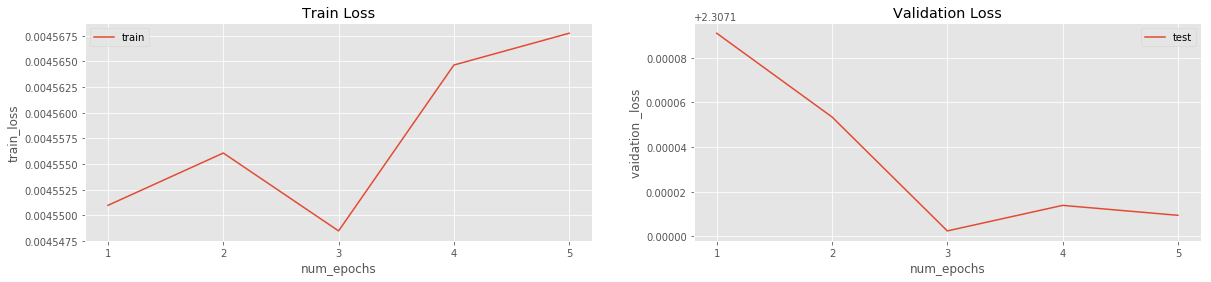

In [16]:
plot_graphs(train_loss, valid_loss, n_epochs)

# Ensembling Models

**Ensemble methods is a machine learning technique that combines several base models in order to produce one optimal predictive model.  Ensemble methods usually produces more accurate solutions than a single model would. This has been the case in a number of machine learning competitions, where the winning solutions used ensemble methods. **
![](http://images.slideplayer.com/37/10747814/slides/slide_2.jpg)
You can find more detailed and advanced explanation [here](https://www.springer.com/in/book/9781441993250)
<br/>
Finally, it's time to get hands dirty on ensemble. I have also mentioned the layer dims after each conv filter is applied.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
    
        #1st net
        self.conv1_1 = nn.Conv2d(1, 4, kernel_size=(4, 4), padding = (3, 3), stride=(2, 2)) #34 * 34
        self.conv1_2 = nn.Conv2d(4, 8, kernel_size=(4, 4), padding = (2, 2), stride=(2, 2)) #18 * 18 #mp
        self.fc1_1 = nn.Linear(8 * 9 * 9, 32) #dropout = 0.2
        self.fc1_1_drop = nn.Dropout(p=0.2)
        self.fc1_2 = nn.Linear(32, 10)
    
        #2nd net
        self.conv2_1 = nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #64 * 64
        self.conv2_2 = nn.Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #64 * 64 #mp
        self.conv2_2_drop = nn.Dropout2d()
        self.conv2_3 = nn.Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #64 * 64
        self.conv2_4 = nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #64 * 64 #mp
        self.conv2_4_drop = nn.Dropout2d()
        self.fc2_1 = nn.Linear(24 * 16 * 16, 120) #dropout = 0.5
        self.fc2_1_drop = nn.Dropout(p=0.5)
        self.fc2_2 = nn.Linear(120, 10)
    
        #3rd net
        self.conv3_1 = nn.Conv2d(1, 4, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2)) #22 * 22
        self.conv3_2 = nn.Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #22 * 22 #mp
        self.conv3_3 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) #11 * 11
        self.fc3_1 = nn.Linear(16 * 11 * 11, 64) #dropout = 0.4
        self.fc3_1_drop = nn.Dropout(p=0.4)
        self.fc3_2 = nn.Linear(64, 10)

    def forward(self, x, y, z):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.pool(self.conv1_2(x)))
        x = x.view(-1, 648) #can also do x.view(-1, 1)
        x = F.relu(self.fc1_1(x))
        x = F.dropout(x, training = self.training)
        x = F.relu(self.fc1_2(x))

        y = F.relu(self.conv2_1(y))
        y = F.relu(self.pool(self.conv2_2_drop(self.conv2_2(y))))
        y = F.relu(self.conv2_3(y))
        y = F.relu(self.pool(self.conv2_4_drop(self.conv2_4(y))))
        y = y.view(-1, 256 * 24)
        y = F.relu(self.fc2_1_drop(self.fc2_1(y)))
        y = F.relu(self.fc2_2(y))

        z = F.relu(self.conv3_1(z))
        z = F.relu(self.pool(self.conv3_2(z)))
        z = F.relu(self.conv3_3(z))
        z = z.view(-1, 16 * 121)
        z = F.relu(self.fc3_1_drop(self.fc3_1(z)))
        z = F.relu(self.fc3_2(z))

        x = torch.cat((x, y, z))
        return F.sigmoid(x)

In [18]:
def train_ensemble(epoch):
    model.train()
    exp_lr_scheduler.step()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        #print(data.size())
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #print(target)
        optimizer.zero_grad()
        target = torch.cat((target, target, target))
        output  = model(data, data, data)
        loss = criterion(output, target)
        #output_list = [model(data, data, data).unsqueeze(0) for model in model_list]
        #output = torch.mean(torch.cat(output_list), 0).squeeze()
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [19]:
def evaluate_ensemble(data_loader):
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        target = torch.cat((target, target, target))
        output  = model(data, data, data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    print('\nAverage Validation loss: {:.5f}\n'.format(loss))

In [20]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

n_epochs = 5

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    train_ensemble(epoch)
    evaluate_ensemble(test_loader)

Train Epoch: 0 [400/2020 (20%)]	Loss: 2.304277
Train Epoch: 0 [800/2020 (40%)]	Loss: 2.300310
Train Epoch: 0 [1200/2020 (59%)]	Loss: 2.306827
Train Epoch: 0 [1600/2020 (79%)]	Loss: 2.307489
Train Epoch: 0 [2000/2020 (99%)]	Loss: 2.304933

Average Validation loss: 6.90947

Train Epoch: 1 [400/2020 (20%)]	Loss: 2.306577
Train Epoch: 1 [800/2020 (40%)]	Loss: 2.300742
Train Epoch: 1 [1200/2020 (59%)]	Loss: 2.303270
Train Epoch: 1 [1600/2020 (79%)]	Loss: 2.302295
Train Epoch: 1 [2000/2020 (99%)]	Loss: 2.304229

Average Validation loss: 6.91038

Train Epoch: 2 [400/2020 (20%)]	Loss: 2.304327
Train Epoch: 2 [800/2020 (40%)]	Loss: 2.304566
Train Epoch: 2 [1200/2020 (59%)]	Loss: 2.305208
Train Epoch: 2 [1600/2020 (79%)]	Loss: 2.303046
Train Epoch: 2 [2000/2020 (99%)]	Loss: 2.306111

Average Validation loss: 6.89122

Train Epoch: 3 [400/2020 (20%)]	Loss: 2.304978
Train Epoch: 3 [800/2020 (40%)]	Loss: 2.302641
Train Epoch: 3 [1200/2020 (59%)]	Loss: 2.299280
Train Epoch: 3 [1600/2020 (79%)]	Loss: 

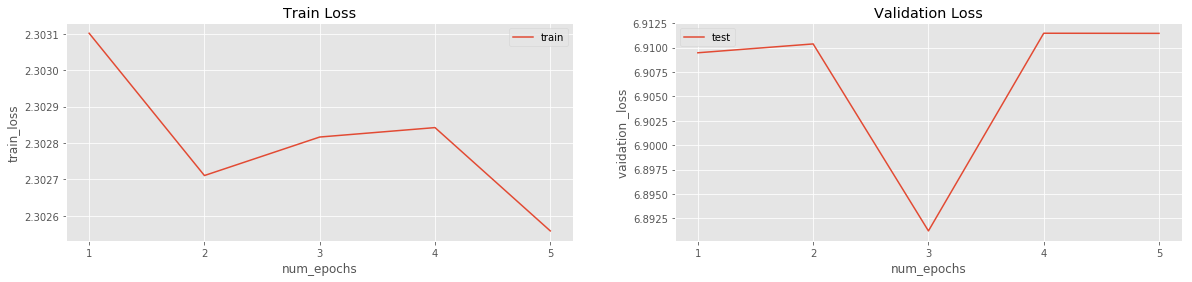

In [21]:
plot_graphs(train_loss, valid_loss, n_epochs)


**Please give your feedback on this script and Upvote if you liked it.**